# Assignment 4

# Some of the top ten Rules for Computational Analysis that we will be considering in this assignment

Rule 1: Tell a story for an audience

Rule 2: Document the process, not just the results

Rule 3: Use cell divisions to make steps clear

Rule 4: Modularize code

Rule 5: Record dependencies

Ref: https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1007007


In [1]:
#Rule 5: Record dependencies
# Lets import all the libraries that are needed for the amalysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Reading the strava data
df = pd.read_csv("strava.csv")
df.columns

Index(['Air Power', 'Cadence', 'Form Power', 'Ground Time',
       'Leg Spring Stiffness', 'Power', 'Vertical Oscillation', 'altitude',
       'cadence', 'datafile', 'distance', 'enhanced_altitude',
       'enhanced_speed', 'fractional_cadence', 'heart_rate', 'position_lat',
       'position_long', 'speed', 'timestamp', 'unknown_87', 'unknown_88',
       'unknown_90'],
      dtype='object')

# Description of the fields as per the assignment instructions

In [3]:
# Cadence: rpm
# Ground time: milliseconds
# Vertical oscillation: centimeters
# Distance, Altitude, and Enhanced Altitude: meters
# Longitude and Latitude: semicircles (radians)
# Air and Form Power: watts
# Leg Spring Stiffness: kN/m
# Speed: m/s
# On further inspection it appears that Speed is in mm/s

In [4]:
#Lets create some Day, Hour and Name of the Day columns
#Appears that the format od date is yyyy-mm-dd
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['dates'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.day_name()

In [5]:
# Converting lat and long to degrees based on the lecture notebooks
df["position_lat_degrees"] = df["position_lat"] * ( 180 / 2**31 )
df["position_long_degrees"] = df["position_long"] * ( 180 / 2**31 )

In [6]:
# Converting hour of the day to a more relatable terminology
def hr_band(x):
    band = "Late Night"
    if x >=4 and x<8:
        band = "Early Morning"
    if x >=8 and x<12:
        band = "Late Morning"
    if x >=12 and x<16:
        band = "Afternoon"
    if x >=16 and x<19:
        band = "Evening"
    if x >=19 and x<22:
        band = "Late Evening"
    return band
    
df['hour_band'] = df['hour'].apply(lambda x: hr_band(x))

In [7]:
# In case we dont to only investigate the interesting variables
# var_interest = ['timestamp','dates','hour','day','weekday','position_lat_degrees','position_long_degrees',\
# 'speed','heart_rate','Air Power','Form Power','Cadence','Power','altitude','distance','hour_band']
# df = df[var_interest]

In [8]:
# We are defining the order here for the heatmap we will create in the next cells
order_weekdays = ['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
oder_daytime = ['Early Morning','Late Morning','Afternoon','Evening','Late Evening','Late Night']

In [9]:
#Rule 4: Modularize code
# In case more heatmaps are needed to be created than the function pivot_table can be used to generate the right dataframe
def pivot_data(col,index,val,agg, order1 = None, order2= None):
    df1 = pd.pivot_table(df, values =val, index =index,
                         columns =col, aggfunc=agg)
    df1 = df1[order1]
    df1 = df1.reindex(order2)
    return df1
df2 = pivot_data('weekday','hour_band','timestamp','count', order_weekdays,oder_daytime)

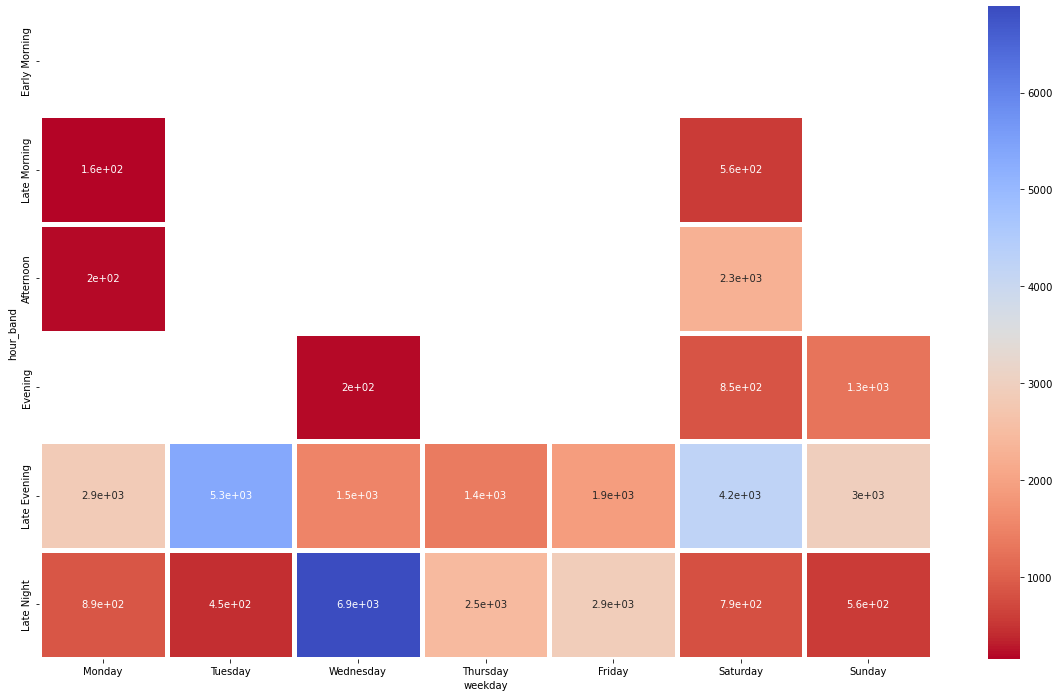

In [10]:
#Lets create a heatmap to see check exactly Prof. does the running.
fig, ax = plt.subplots(figsize = (20, 12))
sns.heatmap(df2, cmap ='coolwarm_r', linewidths = 5, annot = True)
plt.show()

# Story 1

As can be seen in the heatmap, Prof. runs in the unusual hours and this is probably not very healthy.

Wednesday Late Night is when Prof. has been running the most followed by Tuesday Late Evening and Saturday Late Evening.

I would advise Prof. to run Early Morning and as can be seen Prof. has never went out in Early Morning slot. I reccomend to change the running time and make it either in Early Morning or Evening

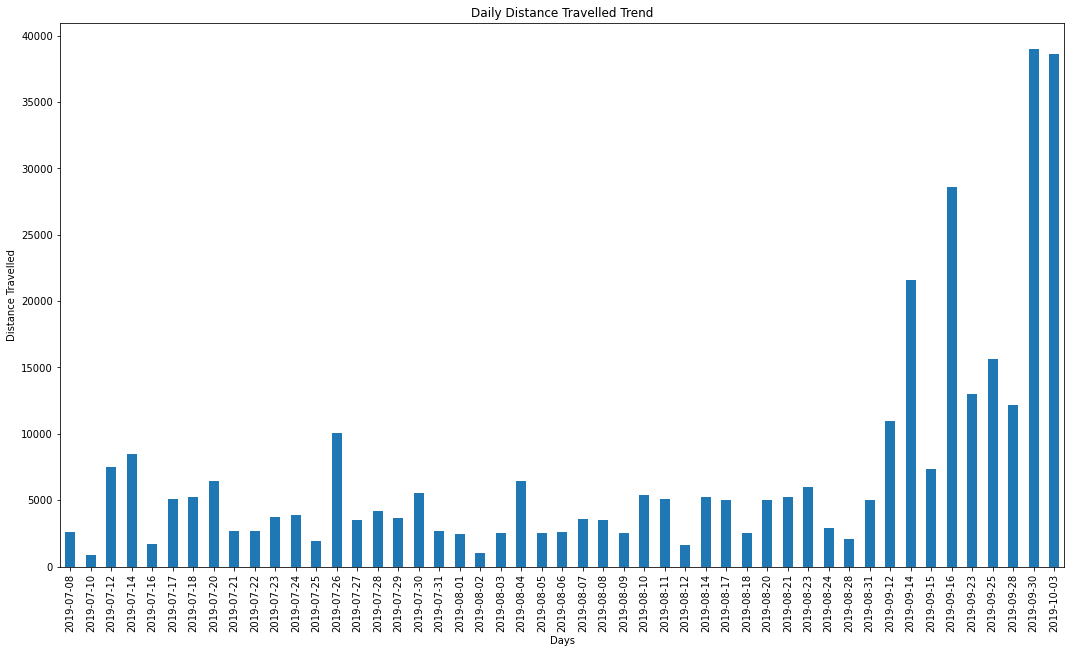

In [11]:
# Total Distance covered is the max of the distance at the level of Day.
df['dates'] = df['dates'].astype(str)
fig, ax = plt.subplots(figsize=(18,10))
df.groupby('dates')['distance'].max().plot.bar(ax = ax)
ax.set_title('Daily Distance Travelled Trend')
plt.xlabel('Days')
plt.ylabel('Distance Travelled')
plt.show()

# Story 2
From the above chart it looks like the Prof. has been hitting it really hard during the last few days and I advide him to slow down a bit and don't over do the workout.

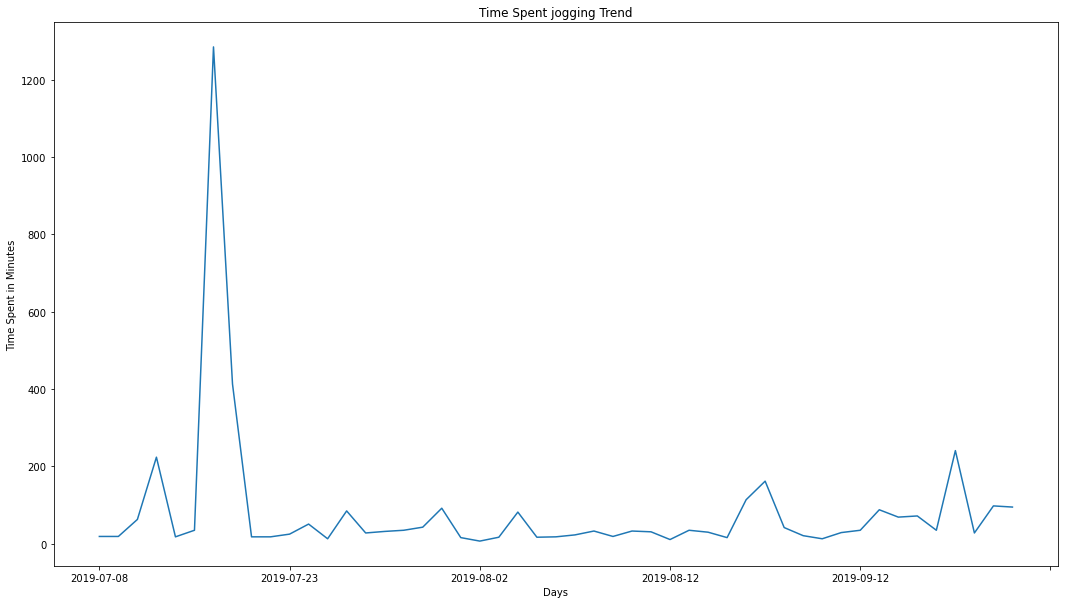

In [12]:
#Lets define Time Spend jogging on a Day as the last timestamp - first timestamp of the day and convert this into minutes
fig, ax = plt.subplots(figsize=(18,10))
(df.groupby('dates')['timestamp'].last() - df.groupby('dates')['timestamp'].first()).astype('timedelta64[m]').plot.line(ax = ax)
ax.set_title('Time Spent jogging Trend')
plt.xlabel('Days')
plt.ylabel('Time Spent in Minutes')
plt.show()

In [13]:
print (f"Max time spent on jogging of {(df.groupby('dates')['timestamp'].last() - df.groupby('dates')['timestamp'].first()).max()} happened on {(df.groupby('dates')['timestamp'].last() - df.groupby('dates')['timestamp'].first()).idxmax()}")

Max time spent on jogging of 0 days 21:25:05 happened on 2019-07-18


In [14]:
# As can be seen that 21hours is an outlier, may be Prof had multiple round of running that day. But we need to treat this outlier.
# I am replacing this value with the third largest value of duration

In [15]:
# Finding the 3rd largest duration value
third_largest = (df.groupby('dates')['timestamp'].last() - df.groupby('dates')['timestamp'].first()).astype('timedelta64[m]').nlargest(3)[-1]

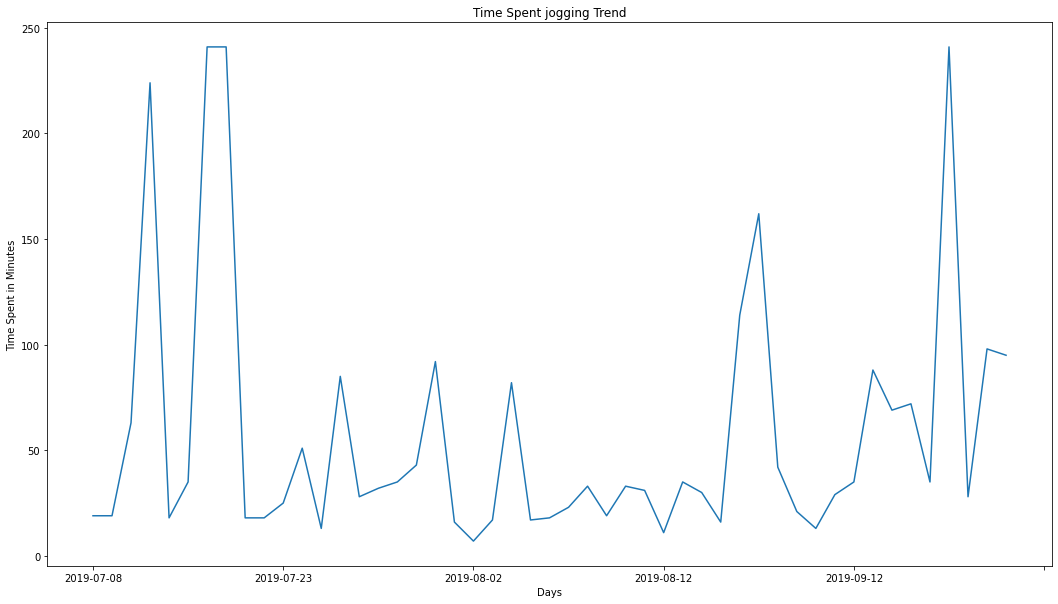

In [16]:
#  Lets plot the graph having taken care of the outlier
fig, ax = plt.subplots(figsize=(18,10))
(df.groupby('dates')['timestamp'].last() - df.groupby('dates')['timestamp'].first()).astype('timedelta64[m]').clip(upper = third_largest).plot.line(ax = ax)
ax.set_title('Time Spent jogging Trend')
plt.xlabel('Days')
plt.ylabel('Time Spent in Minutes')
plt.show()

# Story 3

As can be seen based on the above Chart that Prof. was spending unusually high amount of time jogging during the first few days, he then optimized it and then again the duration seems to have spiked.

I suggest Prof. should be consistent in the time he spends for running each day

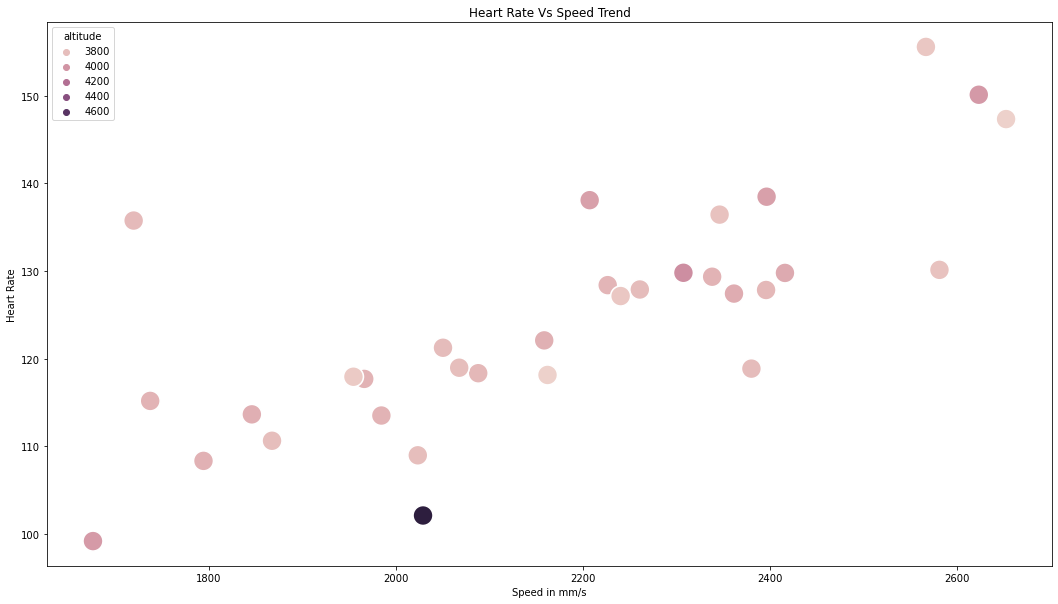

In [17]:
fig, ax = plt.subplots(figsize=(18,10))
sns.scatterplot(x=df.groupby('dates')['speed'].mean(), y=df.groupby('dates')['heart_rate'].mean(),hue=df.groupby('dates')['altitude'].mean(), s= 400)
ax.set_title('Heart Rate Vs Speed Trend')
plt.xlabel('Speed in mm/s')
plt.ylabel('Heart Rate')
plt.show()

# Story 4
Above Chart shows a linear relationship between speed and heart rate.
Also it appears that at unusually high speed the heart rate goes unusually high.
There I reccomend Prof. to limit the speed of running.

# Time for Advanced plot
Lets explore the route of running

In [18]:
image=plt.imread("map.png")
import math
def lat2y(a):
  return 180.0/math.pi*math.log(math.tan(math.pi/4.0+a*(math.pi/180.0)/2.0))
df["position_lat_degrees_mercantor"]=df["position_lat_degrees"].apply(lat2y)

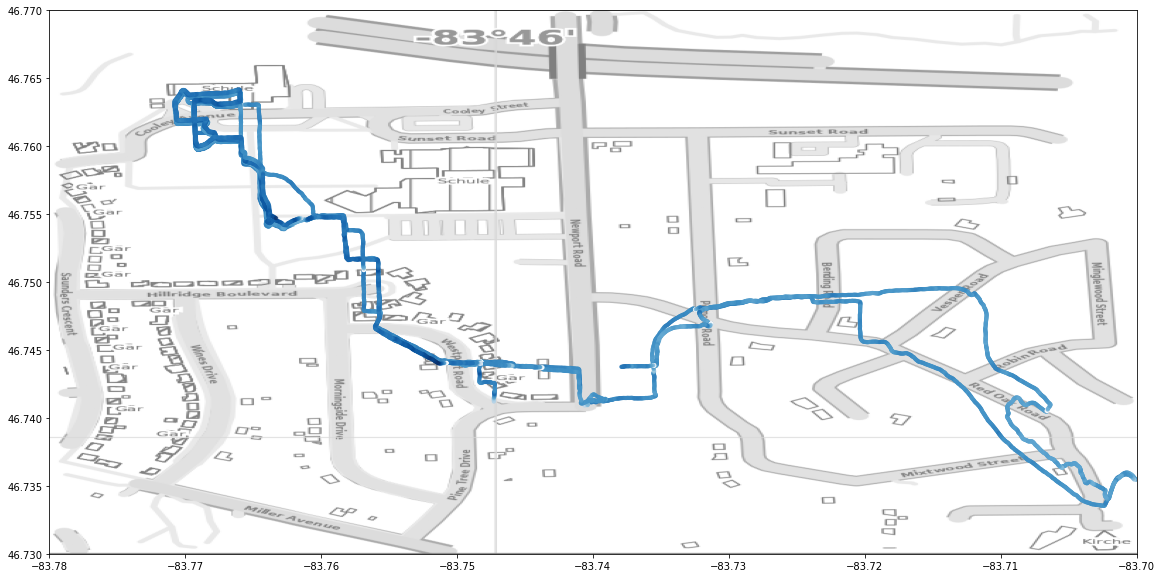

In [19]:
fig, ax = plt.subplots(figsize=(30,10))
# plt.imshow(image, alpha=0.5, extent=[df["position_long_degrees"].min(),df["position_long_degrees"].max(),df["position_lat_degrees_mercantor"].min(),df["position_lat_degrees_mercantor"].max()])
plt.imshow(image, alpha=0.5, extent=[-83.78,-83.7,46.73,46.77])
temp_df = df[(df["position_long_degrees"] >=-83.78) & (df["position_long_degrees"] <=-83.7)]
plt.scatter(temp_df["position_long_degrees"],temp_df["position_lat_degrees_mercantor"],
            s=10, c=temp_df["Power"], cmap='Blues', alpha=0.5)
plt.show()


# Observation
On inspecting data it was observed that the running track of the Prof. is mostly restrcited to 2 clusters.

In the above chart we are observing the one with more data.

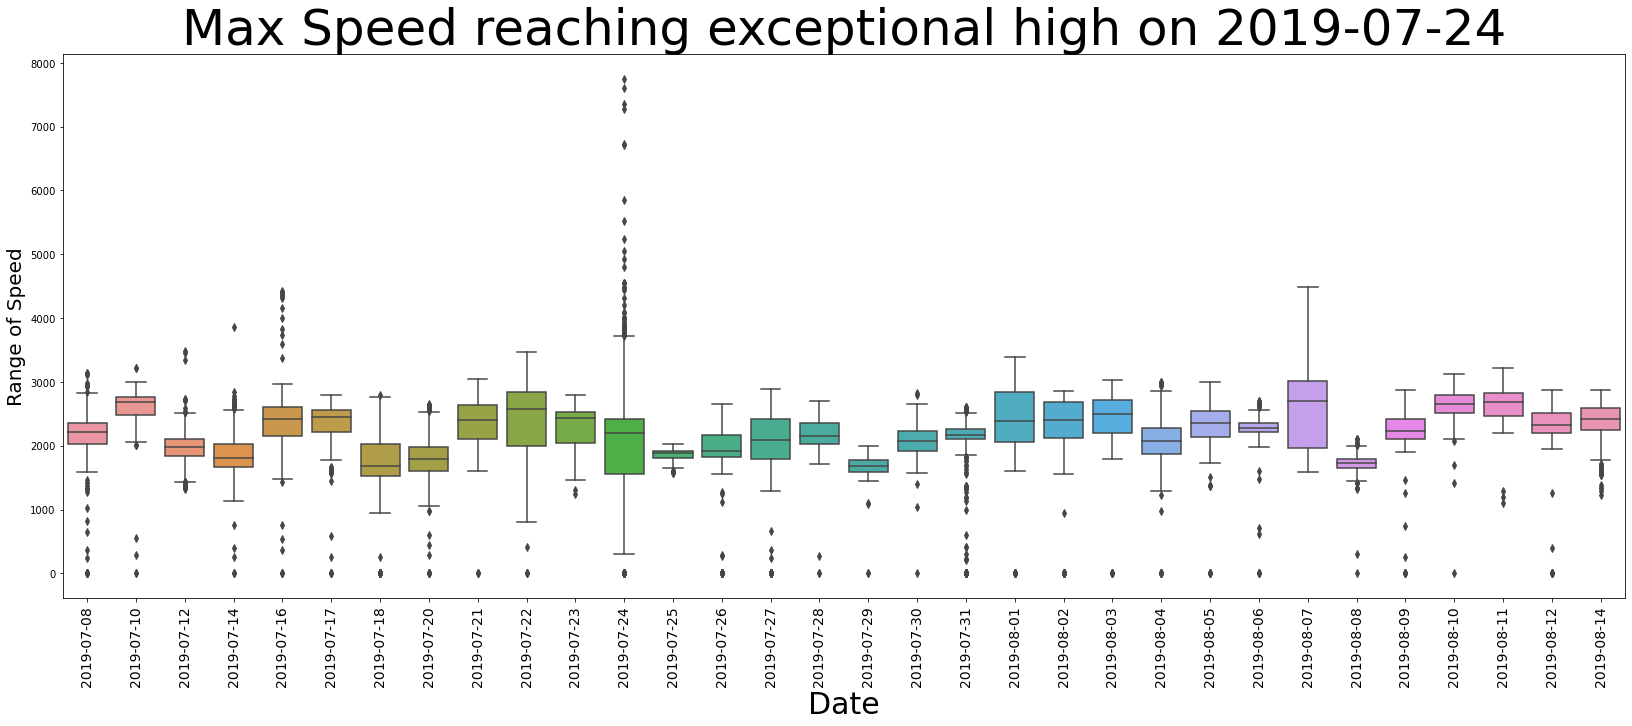

In [20]:
max_date = df[df['speed'] == df['speed'].max()]['dates'].iloc[0]

fig, ax = plt.subplots(figsize=(28,10))
sns.boxplot(x = 'dates', y = 'speed', data = df[~df['speed'].isna()], ax=ax)
ax.set_title("cc")
ax.set_title(f"Max Speed reaching exceptional high on {max_date}",fontsize=50)
ax.set_xlabel("Date",fontsize=30)
plt.xticks(fontsize=14, rotation=90)
ax.set_ylabel("Range of Speed",fontsize=20)
plt.show()

# Story 5
As seen in above chart, Prof. reached probably dangerously high speed on 24th of July and such an extreme effort in running should be avoided.

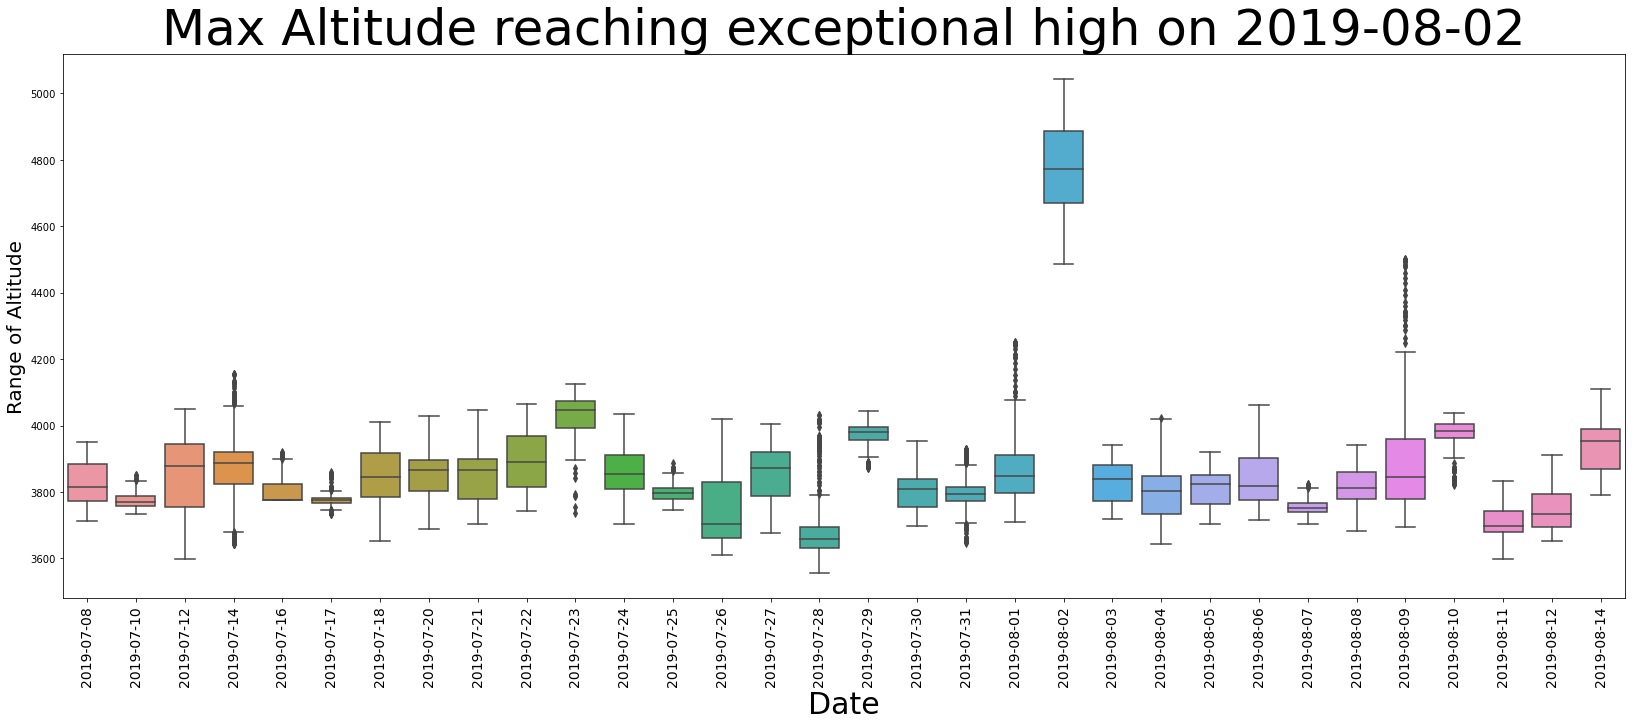

In [21]:
max_date = df[df['altitude'] == df['altitude'].max()]['dates'].iloc[0]
fig, ax = plt.subplots(figsize=(28,10))
sns.boxplot(x = 'dates', y = 'altitude', data = df[~df['altitude'].isna()], ax=ax)
ax.set_title(f"Max Altitude reaching exceptional high on {max_date}",fontsize=50)
ax.set_xlabel("Date",fontsize=30)
plt.xticks(fontsize=14, rotation=90)
ax.set_ylabel("Range of Altitude",fontsize=20)
plt.show()

# Story 6
Again Prof. should avoid exceptionally high altitudes and should probably run at an altitude moe suitable for the body

In [22]:
# Lets define average daily speed as total distance for the day / total time spent running on that day

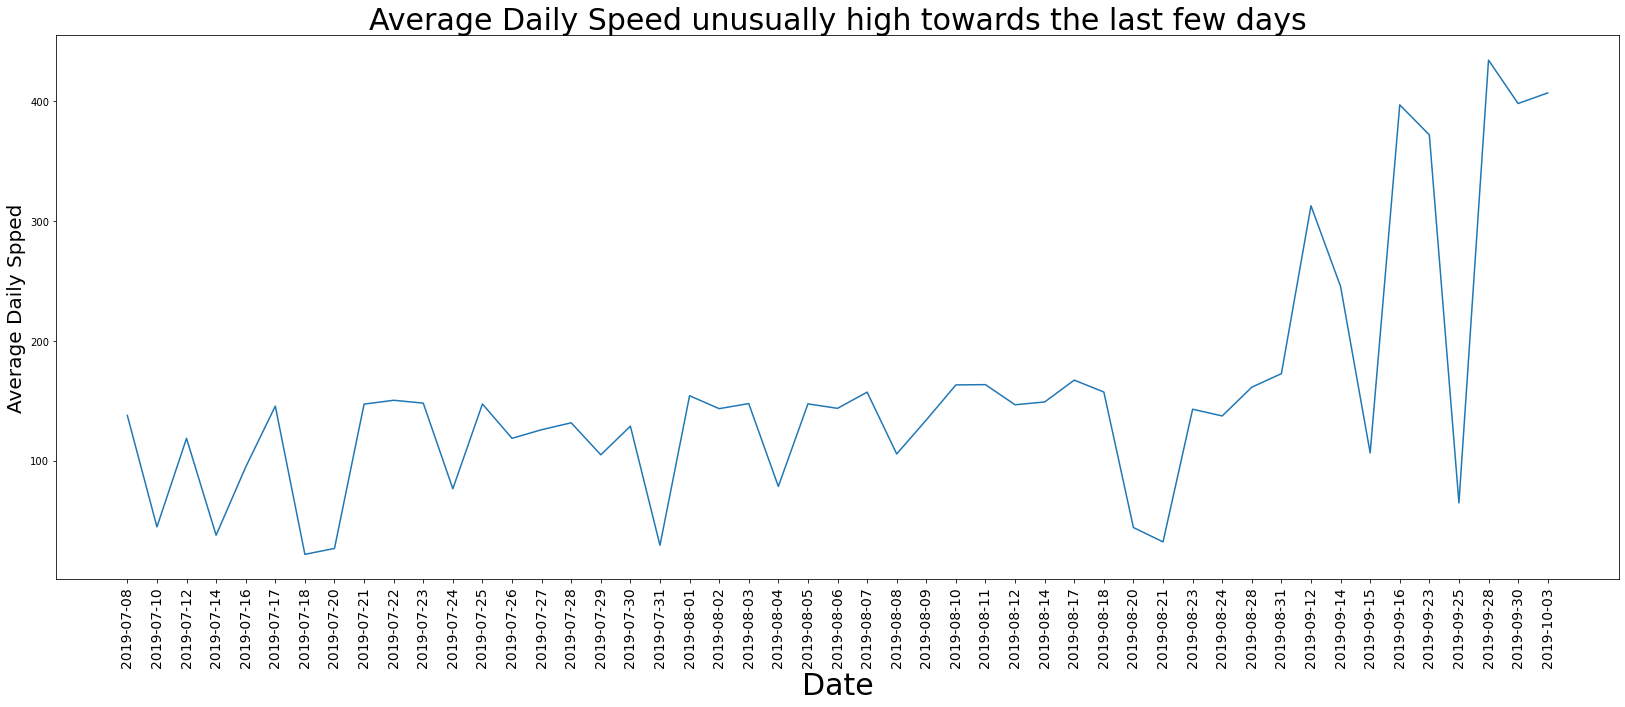

In [23]:
df3 = (df.groupby('dates')['timestamp'].last() - df.groupby('dates')['timestamp'].first()).astype('timedelta64[m]').clip(upper = third_largest)

df3 = pd.concat([df3, df.groupby('dates')['distance'].max()], axis=1)

df3 = df3.reset_index()

df3['average_daily_speed'] = df3['distance']/df3['timestamp']

fig, ax = plt.subplots(figsize=(28,10))
plt.plot(df3['dates'],df3['average_daily_speed'])
ax.set_title(f"Average Daily Speed unusually high towards the last few days",fontsize=30)
ax.set_xlabel("Date",fontsize=30)
plt.xticks(fontsize=14, rotation=90)
ax.set_ylabel("Average Daily Spped",fontsize=20)
plt.show()

# Story 7
Prof. should slow down a bit in terms of the speed he runs.

# Prof. should consider the above suggestions for a more better result.